In [2]:
import numpy as np
import timeit
import sys
import pandas as pd
from typing import NamedTuple, List, Tuple

# MCTS code imports
sys.path.append("..")  # Adds higher directory to python modules path.
from main import MeasurementControlEnvironment
from utils import get_ellipse_scaling

In [83]:
class ObjectTuple(NamedTuple):
    object_type: str         # occlusion, obstacle, ooi
    shape: str               # circle, 4polygon
    mean: np.ndarray         # [x, y]
    ooi_id: int=None
    points: np.ndarray=None  # [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
    covariances: List[np.ndarray]=None
    radius: float=None

obj1 = ObjectTuple(object_type='occlusion',
                   shape='circle',
                   mean=np.array([50, 45]),
                   radius=5.0
)

obj2 = ObjectTuple(object_type='obstacle',
                   shape='4polygon',
                   mean=np.array([10, 10]),
                   points=np.array([[10, 10],[14, 10], [14, 14], [10, 14]])
)

obj3 = ObjectTuple(object_type='occlusion',
                   shape='circle',
                   mean=np.array([40, 40]),
                   radius=1.0
)

obj4 = ObjectTuple(object_type='occlusion',
                   shape='4polygon',
                   mean=np.array([30, 30]),
                   points=np.array([[30, 30],[34, 30], [34, 34], [30, 34]])
)

obj5 = ObjectTuple(object_type='ooi',
                   shape='4polygon',
                   mean=np.array([62, 62]),
                   ooi_id=0,
                   points=np.array([[60, 60],[64, 60], [64, 64], [60, 64]]),
                   covariances=[np.diag([3.5, 2.5]),
                                np.diag([3.5, 2.5]),
                                np.diag([3.5, 2.5]),
                                np.diag([3.5, 2.5])]
)


df = pd.DataFrame([obj1, obj2, obj3, obj4, obj5])
df.head()

,object_type,shape,mean,ooi_id,points,covariances,radius
0,occlusion,circle,"[50, 45]",NaN,None,None,5.0
1,obstacle,4polygon,"[10, 10]",NaN,"[[10, 10], [14, 10], [14, 14], [10, 14]]",None,NaN
2,occlusion,circle,"[40, 40]",NaN,None,None,1.0
3,occlusion,4polygon,"[30, 30]",NaN,"[[30, 30], [34, 30], [34, 34], [30, 34]]",None,NaN
4,ooi,4polygon,"[62, 62]",0.0,"[[60, 60], [64, 60], [64, 64], [60, 64]]","[[[3.5, 0.0], [0.0, 2.5]], [[3.5, 0.0], [0.0, ...",NaN


In [84]:
class ObjectManager:
    def __init__(self, env, df: pd.DataFrame, car_collision_radius: float, car_sensor_range: float, car_max_bearing: float):
        self.env = env
        self.df = df
        self.car_collision_radius = car_collision_radius
        self.car_sensor_range = car_sensor_range
        self.car_max_bearing = car_max_bearing
        
    def draw_objects(self, car_state):
        # Iterate through the rows of the dataframe
        for tuple in df.itertuples(index=True, name='ObjectTuple'):
            # Draw the car collision radius
            self.env.ui.draw_circle(car_state[0:2], self.car_collision_radius, color='r', facecolor='none', alpha=0.1)
            
            if tuple.object_type == 'obstacle':
                if tuple.shape == '4polygon':
                    # Draw the polygon
                    self.env.ui.draw_polygon(tuple.points, linestyle='-', color='r', facecolor='r', alpha=0.2)
                elif tuple.shape == 'circle':
                    # Draw the circle
                    self.env.ui.draw_circle(tuple.mean, tuple.radius, color='r', facecolor='r', alpha=0.2)
                else:
                    raise ValueError('Unknown shape')
            elif tuple.object_type == 'occlusion':
                if tuple.shape == '4polygon':
                    # Draw the polygon
                    self.env.ui.draw_polygon(tuple.points, linestyle='-', color='y', facecolor='y', alpha=0.3)
                elif tuple.shape == 'circle':
                    # Draw the circle
                    self.env.ui.draw_circle(tuple.mean, tuple.radius, color='y', facecolor='y', alpha=0.3)
                else:
                    raise ValueError('Unknown shape')
                
            elif tuple.object_type == 'ooi':
                if tuple.shape != '4polygon':
                    raise ValueError('OOIs must be 4polygons')
                # Draw the polygon
                self.env.ui.draw_polygon(tuple.points, color='b', facecolor='None', linestyle='--', alpha=1.0)
                
                # Draw the points
                for point in tuple.points:
                    self.env.ui.draw_point(point, color='cyan')
                    
                # Draw the covariance ellipses
                for pt, cov in zip(tuple.points, tuple.covariances):
                    scalings, angle = get_ellipse_scaling(cov)
                    self.env.ui.draw_ellipse(pt, scalings[0], scalings[1], angle=angle, color='b', alpha=0.25, linestyle='-')
                    
    def collision_check(self, car_state, draw=False):
        # First filter out any objects whose mean is farther than the car collision radius plus a buffer
        mean_in_range = np.linalg.norm(np.vstack(self.df['mean']) - car_state[0:2], axis=1) < self.car_collision_radius + 2.0
        df_close = self.df[mean_in_range]
        
        # If there is none close, return the empty dataframe
        if df_close.empty:
            return df_close
        
        # First check the circle objects
        df_circle = df_close[self.df['shape'] == 'circle']
        
        # Find the distance between the car and the circle centers
        car_pos = car_state[0:2]
        circle_centers = np.vstack(df_circle['mean'].values)
        distances = np.linalg.norm(circle_centers - car_pos, axis=1)
        
        # Check if the distance is less than both radii combined
        offending_obstacles = distances < (self.car_collision_radius + df_circle['radius'].values)
        
        # Convert to indeces of the dataframe
        offending_circle_obstacle_idx = df_circle[offending_obstacles].index
        
        # Now check the polygon objects
        df_poly = self.df[self.df['shape'] == '4polygon']
        
        # Get the distances of all polygon points to the car
        poly_points = np.vstack(df_poly['points'].values)
        distances = np.linalg.norm(poly_points - car_pos, axis=1)
        
        # Offending points are those that are less than the car collision radius
        offending_poly_points = distances < self.car_collision_radius # Get boolean array of each point
        offending_poly_points_reshaped = offending_poly_points.reshape(-1, 4) # Convert to a row for each object and 4 bools per object
        offending_poly_obstacles = np.logical_or.reduce(offending_poly_points_reshaped, axis=1) # Find what rows have any offending points
        
        # Take the offending rows and convert to indeces of the dataframe
        offending_poly_obstacle_idx = df_poly[offending_poly_obstacles].index
        
        # Return the rows of the input dataframe that are offending
        return self.df.loc[offending_circle_obstacle_idx.union(offending_poly_obstacle_idx)]
    
    def occlusion_check(self, car_state):
        # First remove objects based on mean that are outside the sensor range or bearing with a buffer
        car_to_obj_means = np.vstack(self.df['mean']) - car_state[0:2]
        ranges = np.linalg.norm(car_to_obj_means, axis=1)
        self.df['range'] = ranges # Save the range to the dataframe so we can sort by it in later step
        mean_in_range = ranges < self.car_sensor_range + 2.0
        bearing_in_range = np.abs(np.arctan2(car_to_obj_means[:,1], car_to_obj_means[:,0]) - car_state[3]) < self.car_max_bearing + np.radians(10)
        df_observable = self.df[mean_in_range & bearing_in_range]
        
        # If there is no OOIs in range, which we are doing the occlusion check for, return an empty dataframe
        df_ooi = df_observable[df_observable['object_type'] == 'ooi']
        if df_ooi.empty:
            return pd.DataFrame()
        
        # Do an initial check to see if there are any OOIs which are within sensor range and bearing
        ooi_means = np.vstack(df_ooi['mean'])
        ooi_in_range = np.linalg.norm(ooi_means - car_state[0:2], axis=1) < self.car_sensor_range + 2.0
        ooi_in_bearing = np.arctan2(ooi_means[:,1] - car_state[1], ooi_means[:,0] - car_state[0]) - car_state[3] < self.car_max_bearing + np.radians(10)
        
        # If there are no OOIs in range and bearing, return an empty dataframe
        if not np.any(ooi_in_range & ooi_in_bearing):
            return pd.DataFrame()
        
        # Now sort the observable objects by range
        df_range_sorted = df_observable.sort_values(by='range')
        
        # Now iterate through objects in order of increasing range
        occluded_bearings = np.empty((0,2)) # Maintained to check if an object is occluded
        observations = {} # Maintained to store the observations of the OOIs {ooi_id: [idx0, ..., idxn]}
        for tuple in df_range_sorted.itertuples(index=True, name='ObjectTuple'):
            if tuple.object_type == 'ooi':
                # Get the points, bearings and ranges of the points
                points = tuple.points
                bearings = np.arctan2(points[:,1] - car_state[1], points[:,0] - car_state[0]) - car_state[3]
                ranges = np.linalg.norm(points - car_state[0:2], axis=1)
                
                # Sort by ranges and get the 2 closest points
                sorted_indices = np.argsort(ranges)
                
                # Take the two closest points bearings and sort them by increasing bearing for interval check
                closest_two_bearing_interval = np.sort(bearings[sorted_indices[0:2]])
                
                # Now we can check if the other two points are occluded by the OOI itself by seeing if they lie in the closest 2 bearing interval
                is_point_not_ooi_occluded = np.ones(4, dtype=bool) # Initialize to true for the close corners
                for i in sorted_indices[2:]: # Iterate through the farther two points
                    # Not if the bearing is greater than the min and less than the max
                    is_point_not_ooi_occluded[i] = ~((closest_two_bearing_interval[0] < bearings[i]) & (bearings[i] < closest_two_bearing_interval[1]))
                
                # Take the indices of the non-occluded points and sort them by increasing index
                non_ooi_occluded_indices = np.arange(4)[is_point_not_ooi_occluded]
                
                # Check for each bearing if it lies in between any intervals of occluded bearings
                non_occluded = np.zeros(non_ooi_occluded_indices.shape[0], dtype=bool)
                print(f'Occluded Bearings: {occluded_bearings}')
                for i, bearing in enumerate(bearings[non_ooi_occluded_indices]):
                    # Not any ((vector of mins < bearing) and (bearing < vector of maxes))
                    non_occluded[i] = ~(np.any((occluded_bearings[:,0] < bearing) & (bearing < occluded_bearings[:,1])))
                    print(f'Bearing: {bearing}, Non-Occluded: {non_occluded[i]}')

                # If there is any non-occluded points, store the observation
                if np.any(non_occluded):
                    # Store the observation of non-occluded points with key of ooi_id
                    observations[tuple.ooi_id] = non_ooi_occluded_indices[non_occluded]
                
            # If the object is a polygon occlusion, add the max and min bearing interval using the points
            elif (tuple.object_type == 'occlusion') & (tuple.shape == '4polygon'):
                # Find the bearings of the points, take the min and max and add to the occluded bearing intervals
                bearings = np.arctan2(tuple.points[:,1] - car_state[1], tuple.points[:,0] - car_state[0]) - car_state[3] # Find the bearing of each point
                occluded_bearings = np.vstack((occluded_bearings, np.array([np.min(bearings), np.max(bearings)]))) # Find the min and max bearing of the object
                print(f'Polygon Occlusion: {np.min(bearings), np.max(bearings)}')
            
            # If the object is a circle occlusion, add the bearing interval using the mean and radius
            elif (tuple.object_type == 'occlusion') & (tuple.shape == 'circle'):
                # Find the bearing of the center point, find the angle to the edge and add to the occluded bearing intervals
                bearing = np.arctan2(tuple.mean[1] - car_state[1], tuple.mean[0] - car_state[0]) - car_state[3]
                mean_to_edge_angle = np.arcsin(tuple.radius / tuple.range)
                occluded_bearings = np.vstack((occluded_bearings, np.array([bearing - mean_to_edge_angle, bearing + mean_to_edge_angle])))
                print(f'Circle Occlusion: {bearing - mean_to_edge_angle, bearing + mean_to_edge_angle}')
                print(f'Bearing: {bearing}, Mean to Edge Angle: {mean_to_edge_angle}')
        
        return observations
        


In [77]:
np.vstack((np.empty((0,2)), np.array([3,4])))

array([[3., 4.]])

Toy Measurement Control Initialized
Circle Occlusion: (0.7146284267352346, 0.8561679000596619)
Bearing: 0.7853981633974483, Mean to Edge Angle: 0.0707697366622136
Circle Occlusion: (-0.3398369094541219, 0.3398369094541219)
Bearing: 0.0, Mean to Edge Angle: 0.3398369094541219
Occluded Bearings: [[ 0.71462843  0.8561679 ]
 [-0.33983691  0.33983691]]
Bearing: -0.32175055439664213, Non-Occluded: False
Bearing: -0.43662715981354117, Non-Occluded: True
Bearing: -0.2860514417173181, Non-Occluded: False
{0.0: array([1])}


,object_type,shape,mean,ooi_id,points,covariances,radius,range
0,occlusion,circle,"[50, 45]",NaN,None,None,5.0,15.000000
1,obstacle,4polygon,"[10, 10]",NaN,"[[10, 10], [14, 10], [14, 14], [10, 14]]",None,NaN,44.721360
2,occlusion,circle,"[40, 40]",NaN,None,None,1.0,14.142136
3,occlusion,4polygon,"[30, 30]",NaN,"[[30, 30], [34, 30], [34, 34], [30, 34]]",None,NaN,20.000000
4,ooi,4polygon,"[62, 62]",0.0,"[[60, 60], [64, 60], [64, 64], [60, 64]]","[[[3.5, 0.0], [0.0, 2.5]], [[3.5, 0.0], [0.0, ...",NaN,34.176015


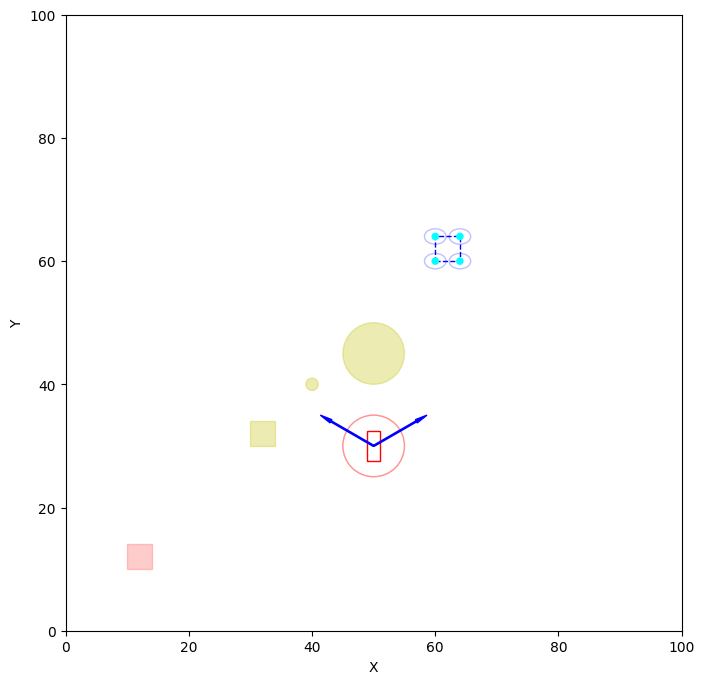

In [85]:
env = MeasurementControlEnvironment()
object_manager = ObjectManager(env, df, car_collision_radius=5.0, 
                               car_sensor_range=40.0, car_max_bearing=np.radians(60))

car_state = np.array([50, 30, 0, np.radians(90), 0, 0])
object_manager.draw_objects(car_state=car_state)
env.car.draw_state(car_state)
env.ui.plot()
df_offending = object_manager.collision_check(car_state=car_state)
observations = object_manager.occlusion_check(car_state=car_state)
print(observations)

df.head()

In [23]:
a = np.array([[2, 4],
              [5, 6]])
b = np.array([1, 3])

not_in_interval = np.zeros(b.shape, dtype=bool)
for i in range(b.shape[0]):
    # Not any (b < vector of mins) and (b > vector of maxes)
    not_in_interval[i] = ~np.any((a[:,0] < b[i]) & (b[i] < a[:,1]))
    
print(not_in_interval)

[ True False]
